In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-26 18:52:44.485311: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 18:52:45.675386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-26 18:52:45.675482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-26 18:52:45.675490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_tests'
background = 50
photons_per_pixel = 400

single_lens_data = np.load(os.path.join(data_path, 'single_lens_measurements.npy'))
double_lens_data = np.load(os.path.join(data_path, 'double_lens_measurements.npy'))
many_lens_data = np.load(os.path.join(data_path, 'many_lens_measurements.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())


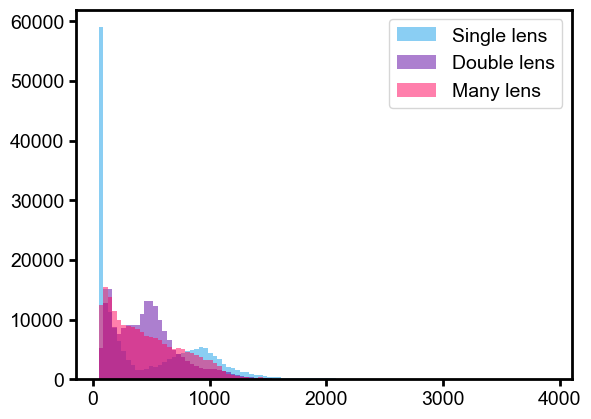

In [3]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

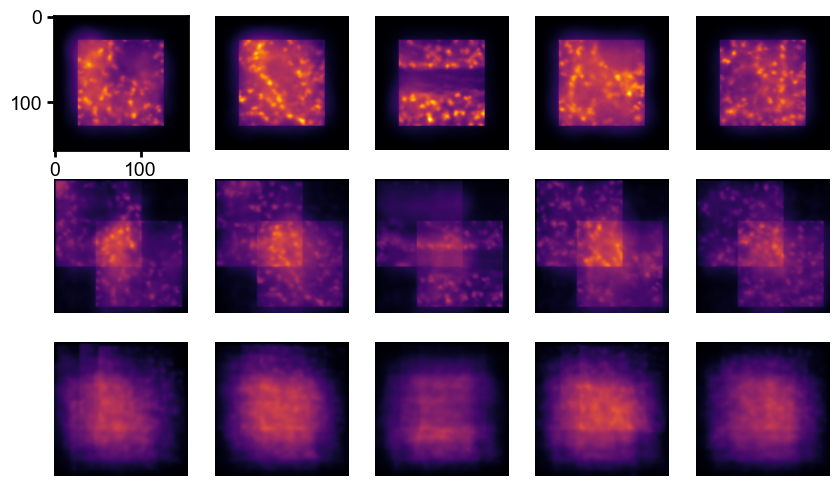

In [4]:
# plot 5 of the initial and final measurements

vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

In [5]:
# Try nearest neighbor distance
from encoding_information.information_estimation import *

patch_size = 80

single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)


@partial(jit, static_argnums=1)
def nearest_neighbors_distance(X, k):
    """
    Compute the distance to the kth nearest neighbor for each point in X by
    exhaustively searching all points in X.
    
    X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
    k : int
    """
    X = X.reshape(X.shape[0], -1)
    distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
    kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
    kth_nn = X[kth_nn_index, :]
    kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
    # kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
    return kth_nn_dist


k = 1000
print(nearest_neighbors_distance(single_lens_patches, k).mean(),
        nearest_neighbors_distance(double_lens_patches, k).mean(), 
        nearest_neighbors_distance(many_lens_patches, k).mean())


100%|██████████| 5000/5000 [00:57<00:00, 87.15it/s] 


2531547.0 1737393.4 1738948.4


# Generate and train

In [6]:
patch_size = 80
prefix = '2_plane_lung_with_background{}_'.format(background)


pcnn_path = data_path + '/pcnn'
gaussian_path = data_path + '/gaussian'

#mkdirs if necessary
for path in [pcnn_path, gaussian_path]:
    if not os.path.exists(path):
        os.makedirs(path)


for i in range(10):

    single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches)
    double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,  verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    # count the number of files in each directory, and then create a suffix for the next file. 
    # assume they are save in files like single_lens_pcnn_1.npy, single_lens_pcnn_2.npy, etc.
    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path) if 'single_lens_pcnn' in f])
                
    suffix = get_next_suffix(pcnn_path)

    np.save(os.path.join(pcnn_path, f'{prefix}_single_lens_pcnn_patch_{patch_size}_{suffix}.npy'), single_lens_mi_pcnn)
    np.save(os.path.join(pcnn_path, f'{prefix}_double_lens_pcnn_patch_{patch_size}_{suffix}.npy'), double_lens_mi_pcnn)
    np.save(os.path.join(pcnn_path, f'{prefix}_many_lens_pcnn_patch_{patch_size}_{suffix}.npy'), many_lens_mi_pcnn)

    np.save(os.path.join(gaussian_path, f'{prefix}_single_lens_gaussian_patch_{patch_size}_{suffix}.npy'), single_lens_mi_pcnn)
    np.save(os.path.join(gaussian_path, f'{prefix}_double_lens_gaussian_patch_{patch_size}_{suffix}.npy'), double_lens_mi_pcnn)
    np.save(os.path.join(gaussian_path, f'{prefix}_many_lens_gaussian_patch_{patch_size}_{suffix}.npy'), many_lens_mi_pcnn)

100%|██████████| 5000/5000 [01:01<00:00, 81.05it/s] 


Initial validation NLL: 683.50


Epoch 1: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Epoch 1: validation NLL: 6.57


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 2: validation NLL: 6.38


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 3: validation NLL: 6.20


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 4: validation NLL: 5.99


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 5: validation NLL: 5.54


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 5.37


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 5.36


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 8: validation NLL: 5.29


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 9: validation NLL: 5.40


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 10: validation NLL: 5.12


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 11: validation NLL: 5.54


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 12: validation NLL: 5.18


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 13: validation NLL: 5.04


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 14: validation NLL: 5.20


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 15: validation NLL: 5.77


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 17: validation NLL: 5.98


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 18: validation NLL: 6.12


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 19: validation NLL: 5.23


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 20: validation NLL: 5.18


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 21: validation NLL: 9.40


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 22: validation NLL: 5.85


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 23: validation NLL: 6.28


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 24: validation NLL: 5.55


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 25: validation NLL: 5.06


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 26: validation NLL: 5.73


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 27: validation NLL: 5.01


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 28: validation NLL: 5.23


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 29: validation NLL: 5.16


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 5.15


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 31: validation NLL: 5.02


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 32: validation NLL: 4.95


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 33: validation NLL: 5.06


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 34: validation NLL: 5.41


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 35: validation NLL: 4.98


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 36: validation NLL: 5.06


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 37: validation NLL: 5.02


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 38: validation NLL: 4.97


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 39: validation NLL: 4.99


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 40: validation NLL: 5.59


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 41: validation NLL: 4.94


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 42: validation NLL: 5.69


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 43: validation NLL: 5.02


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 44: validation NLL: 5.03


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 45: validation NLL: 5.04


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 46: validation NLL: 4.92


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 47: validation NLL: 4.91


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 48: validation NLL: 5.53


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 49: validation NLL: 4.96


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 50: validation NLL: 4.90


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 51: validation NLL: 4.94


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 52: validation NLL: 5.46


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 53: validation NLL: 4.94


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 54: validation NLL: 4.94


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 55: validation NLL: 4.99


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 56: validation NLL: 5.00


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 57: validation NLL: 4.96


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 58: validation NLL: 5.49


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 59: validation NLL: 5.74


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 60: validation NLL: 5.22


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 61: validation NLL: 4.92


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 62: validation NLL: 5.02


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 63: validation NLL: 4.94


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 64: validation NLL: 4.94


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 65: validation NLL: 5.10


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 66: validation NLL: 4.90


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 67: validation NLL: 5.15


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 68: validation NLL: 5.11


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 69: validation NLL: 4.98


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 70: validation NLL: 5.11


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 71: validation NLL: 4.92


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 72: validation NLL: 4.86


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 73: validation NLL: 4.92


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 74: validation NLL: 5.00


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 75: validation NLL: 4.87


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 76: validation NLL: 4.91


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 77: validation NLL: 5.41


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 78: validation NLL: 4.99


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 79: validation NLL: 4.96


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 80: validation NLL: 4.85


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 81: validation NLL: 4.86


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 82: validation NLL: 4.85


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 83: validation NLL: 4.86


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 84: validation NLL: 5.07


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 85: validation NLL: 4.94


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 86: validation NLL: 4.84


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 87: validation NLL: 4.84


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 88: validation NLL: 5.02


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 89: validation NLL: 4.98


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 90: validation NLL: 4.89


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 91: validation NLL: 5.10


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 92: validation NLL: 4.89


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 93: validation NLL: 4.88


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 94: validation NLL: 4.91


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 95: validation NLL: 4.92


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 96: validation NLL: 4.89


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 97: validation NLL: 4.92


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 98: validation NLL: 4.99


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 99: validation NLL: 5.16


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 100: validation NLL: 4.82


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 101: validation NLL: 5.00


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 102: validation NLL: 4.83


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 103: validation NLL: 4.88


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 104: validation NLL: 4.92


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 105: validation NLL: 5.07


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 106: validation NLL: 4.96


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 107: validation NLL: 4.94


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 108: validation NLL: 4.97


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 109: validation NLL: 4.92


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 110: validation NLL: 4.85


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 111: validation NLL: 5.01


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 112: validation NLL: 4.88


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 113: validation NLL: 4.89


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 114: validation NLL: 4.87


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 115: validation NLL: 4.82


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 116: validation NLL: 5.11


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 117: validation NLL: 4.95


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 118: validation NLL: 4.98


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 119: validation NLL: 4.83


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 120: validation NLL: 5.00


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 121: validation NLL: 5.59


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 122: validation NLL: 5.26


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 123: validation NLL: 4.85


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 124: validation NLL: 5.00


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 125: validation NLL: 4.83


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 126: validation NLL: 4.84


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 127: validation NLL: 4.85


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 128: validation NLL: 5.13


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 129: validation NLL: 4.85


Epoch 130: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 130: validation NLL: 5.13


Epoch 131: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 131: validation NLL: 5.76


Epoch 132: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 132: validation NLL: 5.14


Epoch 133: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 133: validation NLL: 5.15


Epoch 134: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 134: validation NLL: 5.13


Epoch 135: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 135: validation NLL: 5.08


Epoch 136: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 136: validation NLL: 4.94


Epoch 137: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 137: validation NLL: 4.94


Epoch 138: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 138: validation NLL: 5.02


Epoch 139: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 139: validation NLL: 5.05


Epoch 140: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 140: validation NLL: 4.96
Estimated H(Y|X) = 4.581 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.830 differential entropy/pixel
Estimated I(Y;X) = 0.359 bits/pixel
Initial validation NLL: 450.56


Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Epoch 1: validation NLL: 6.06


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 2: validation NLL: 5.60


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 3: validation NLL: 5.20


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 4: validation NLL: 5.67


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 5: validation NLL: 5.55


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 5.38


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 7: validation NLL: 5.75


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 8: validation NLL: 5.65


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 9: validation NLL: 4.90


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 10: validation NLL: 5.73


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 11: validation NLL: 4.86


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 12: validation NLL: 5.11


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 13: validation NLL: 4.83


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 14: validation NLL: 5.37


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 15: validation NLL: 4.91


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 16: validation NLL: 4.99


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 4.82


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 18: validation NLL: 5.00


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 4.87


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 20: validation NLL: 5.10


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 21: validation NLL: 4.90


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 22: validation NLL: 4.96


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 23: validation NLL: 4.85


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 24: validation NLL: 4.87


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 25: validation NLL: 4.81


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 26: validation NLL: 4.80


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 27: validation NLL: 4.81


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 28: validation NLL: 4.95


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 29: validation NLL: 4.80


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 30: validation NLL: 4.83


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.80


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 32: validation NLL: 4.80


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 33: validation NLL: 5.26


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 34: validation NLL: 4.84


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 35: validation NLL: 4.82


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 36: validation NLL: 4.78


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 37: validation NLL: 4.79


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 38: validation NLL: 4.78


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 39: validation NLL: 4.78


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 40: validation NLL: 4.78


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 41: validation NLL: 4.80


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 42: validation NLL: 4.91


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 43: validation NLL: 4.77


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 44: validation NLL: 4.85


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 45: validation NLL: 4.97


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 46: validation NLL: 4.81


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 47: validation NLL: 4.78


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 48: validation NLL: 4.78


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 49: validation NLL: 4.78


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 50: validation NLL: 4.77


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 51: validation NLL: 4.77


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 52: validation NLL: 4.79


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 53: validation NLL: 4.79


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 54: validation NLL: 4.76


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 55: validation NLL: 4.77


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 56: validation NLL: 4.78


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 57: validation NLL: 4.77


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 58: validation NLL: 4.80


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 59: validation NLL: 4.78


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 60: validation NLL: 5.54


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 61: validation NLL: 4.84


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 62: validation NLL: 4.79


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 63: validation NLL: 4.95


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 64: validation NLL: 4.78


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 65: validation NLL: 4.77


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 66: validation NLL: 4.77


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 67: validation NLL: 4.77


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 68: validation NLL: 4.78


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 69: validation NLL: 4.79


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 70: validation NLL: 4.77


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 71: validation NLL: 4.80


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 72: validation NLL: 4.77


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 73: validation NLL: 4.76


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 74: validation NLL: 4.84


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 75: validation NLL: 4.77


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 76: validation NLL: 4.79


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 77: validation NLL: 4.77


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 78: validation NLL: 4.76


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 79: validation NLL: 4.79


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 80: validation NLL: 4.76


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 81: validation NLL: 4.76


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 82: validation NLL: 4.80


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 83: validation NLL: 4.86


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 84: validation NLL: 4.78


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 85: validation NLL: 4.81


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 86: validation NLL: 4.79


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 87: validation NLL: 4.75


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 88: validation NLL: 4.78


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 89: validation NLL: 4.80


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 90: validation NLL: 4.75


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 91: validation NLL: 5.47


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 92: validation NLL: 6.81


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 93: validation NLL: 6.81


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 94: validation NLL: 6.81


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 95: validation NLL: 6.81


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 96: validation NLL: 6.81


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 97: validation NLL: 6.81


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 98: validation NLL: 6.81


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 99: validation NLL: 6.81


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 100: validation NLL: 6.81


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 101: validation NLL: 6.81


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 102: validation NLL: 6.81


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 103: validation NLL: 6.81


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 104: validation NLL: 6.81


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 105: validation NLL: 6.81


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 106: validation NLL: 6.81


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 107: validation NLL: 6.81


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 108: validation NLL: 6.81


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 109: validation NLL: 6.81


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 110: validation NLL: 6.81


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 111: validation NLL: 6.81


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 112: validation NLL: 6.81


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 113: validation NLL: 6.81


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 114: validation NLL: 6.81


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 115: validation NLL: 6.81


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 116: validation NLL: 6.81


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 117: validation NLL: 6.81


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 118: validation NLL: 6.81


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 119: validation NLL: 6.81


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 120: validation NLL: 6.81


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 121: validation NLL: 6.81


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 122: validation NLL: 6.81


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 123: validation NLL: 6.81


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 124: validation NLL: 6.81


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 125: validation NLL: 6.81


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 126: validation NLL: 6.81


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 127: validation NLL: 6.81
Estimated H(Y|X) = 4.561 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.749 differential entropy/pixel
Estimated I(Y;X) = 0.271 bits/pixel
Initial validation NLL: 470.17


Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Epoch 1: validation NLL: 5.96


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 2: validation NLL: 5.80


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 3: validation NLL: 5.49


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 4: validation NLL: 5.39


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 5: validation NLL: 5.12


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 6: validation NLL: 5.46


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 5.94


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 8: validation NLL: 4.89


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 9: validation NLL: 4.83


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 10: validation NLL: 5.05


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 11: validation NLL: 5.07


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 12: validation NLL: 4.79


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 14: validation NLL: 4.78


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 15: validation NLL: 4.76


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 16: validation NLL: 4.76


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 5.00


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 18: validation NLL: 4.74


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 4.74


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 20: validation NLL: 4.74


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 21: validation NLL: 4.86


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 22: validation NLL: 4.75


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 23: validation NLL: 4.75


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 24: validation NLL: 4.78


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 25: validation NLL: 4.73


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 26: validation NLL: 5.15


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 4.75


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 28: validation NLL: 4.76


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 4.83


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 4.74


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 31: validation NLL: 4.73


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 32: validation NLL: 4.89


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 33: validation NLL: 4.87


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 34: validation NLL: 4.78


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 35: validation NLL: 4.75


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 36: validation NLL: 5.17


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 4.73


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 38: validation NLL: 4.76


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 39: validation NLL: 4.91


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 40: validation NLL: 4.76


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 41: validation NLL: 4.73


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 42: validation NLL: 4.78


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 43: validation NLL: 4.74


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 44: validation NLL: 4.73


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 45: validation NLL: 4.87


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 46: validation NLL: 4.74


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 47: validation NLL: 4.74


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 48: validation NLL: 4.85


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 49: validation NLL: 4.73


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 50: validation NLL: 4.80


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 51: validation NLL: 4.72


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 52: validation NLL: 5.48


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 53: validation NLL: 5.13


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 54: validation NLL: 4.77


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 55: validation NLL: 4.76


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 56: validation NLL: 4.81


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 57: validation NLL: 4.86


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 58: validation NLL: 4.75


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 59: validation NLL: 4.79


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 60: validation NLL: 4.73


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 61: validation NLL: 4.74


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 62: validation NLL: 4.75


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 63: validation NLL: 4.76


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 64: validation NLL: 4.73


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 65: validation NLL: 4.73


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 66: validation NLL: 4.73


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 67: validation NLL: 4.73


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 68: validation NLL: 4.76


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 69: validation NLL: 4.87


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 70: validation NLL: 4.83


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 71: validation NLL: 4.83


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 72: validation NLL: 4.72


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 73: validation NLL: 4.95


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 74: validation NLL: 4.73


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 75: validation NLL: 4.79


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 76: validation NLL: 6.47


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 77: validation NLL: 5.64


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 78: validation NLL: 5.82


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 79: validation NLL: 6.90


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 80: validation NLL: 6.91


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 81: validation NLL: 6.90


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 82: validation NLL: 6.90


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 83: validation NLL: 6.90


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 84: validation NLL: 6.90


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 85: validation NLL: 6.90


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 86: validation NLL: 6.90


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 87: validation NLL: 6.90


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 88: validation NLL: 6.90


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 89: validation NLL: 6.90


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 90: validation NLL: 6.90


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 91: validation NLL: 6.90
Estimated H(Y|X) = 4.610 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.738 differential entropy/pixel
Estimated I(Y;X) = 0.185 bits/pixel


2024-01-26 20:51:10.630642: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-01-26 21:04:59.343462: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 15m48.712901396s

********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  

trying eigenvalue floor of 0.01


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 1.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 10.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 10.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 100.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 100.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1000.0
Initial validation NLL: 5.15


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]2024-01-26 21:28:23.130118: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 15m28.675297673s

********************************
[Compiling module jit__train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch 1: 100%|██████████| 1/1 [23:21<00:00, 1401.74s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:237: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')
precomputing masks and variances: 100%|██████████| 80/80 [00:05<00:00, 14.63it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:04<00:00, 18.72it/s]


Estimated H(Y|X) = 4.581 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.153 differential entropy/pixel
Estimated I(Y;X) = 0.826 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.01


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 1.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 10.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 10.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 100.0
Initial validation NLL: 7.09


Epoch 1: 100%|██████████| 1/1 [08:38<00:00, 518.40s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:237: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')
precomputing masks and variances: 100%|██████████| 80/80 [00:04<00:00, 19.69it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:04<00:00, 19.21it/s]


Estimated H(Y|X) = 4.561 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6.818 differential entropy/pixel
Estimated I(Y;X) = 3.256 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 100.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1000.0
Initial validation NLL: 5.33


precomputing masks and variances: 100%|██████████| 80/80 [00:03<00:00, 20.98it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:03<00:00, 21.92it/s]


Estimated H(Y|X) = 4.610 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.385 differential entropy/pixel
Estimated I(Y;X) = 1.118 bits/pixel


100%|██████████| 5000/5000 [01:04<00:00, 77.10it/s] 


Initial validation NLL: 709.03


Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 1: validation NLL: 6.44


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 2: validation NLL: 6.50


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 3: validation NLL: 5.89


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 4: validation NLL: 5.81


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 5: validation NLL: 5.55


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 5.43


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 8: validation NLL: 5.20


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 9: validation NLL: 5.41


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 10: validation NLL: 5.88


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 11: validation NLL: 7.24


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 12: validation NLL: 7.10


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 13: validation NLL: 5.78


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 14: validation NLL: 5.37


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 15: validation NLL: 7.03


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 16: validation NLL: 6.30


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 17: validation NLL: 5.47


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 18: validation NLL: 5.73


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 19: validation NLL: 5.13


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 20: validation NLL: 5.45


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 21: validation NLL: 5.36


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 22: validation NLL: 6.73


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 23: validation NLL: 5.76


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 24: validation NLL: 5.26


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 25: validation NLL: 5.21


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 26: validation NLL: 5.61


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 27: validation NLL: 5.55


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 28: validation NLL: 5.38


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 29: validation NLL: 4.97


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 30: validation NLL: 5.02


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 31: validation NLL: 5.23


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 32: validation NLL: 5.22


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 33: validation NLL: 5.62


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 34: validation NLL: 5.44


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 35: validation NLL: 5.60


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 36: validation NLL: 5.36


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 37: validation NLL: 5.06


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 38: validation NLL: 4.94


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 39: validation NLL: 5.03


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 40: validation NLL: 5.03


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 41: validation NLL: 5.01


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 42: validation NLL: 5.12


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 43: validation NLL: 5.30


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 44: validation NLL: 5.68


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 45: validation NLL: 4.91


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 46: validation NLL: 5.16


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 47: validation NLL: 4.97


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 48: validation NLL: 5.07


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 49: validation NLL: 5.08


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 50: validation NLL: 5.07


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 51: validation NLL: 5.00


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 52: validation NLL: 4.96


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 53: validation NLL: 5.20


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 54: validation NLL: 4.89


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 55: validation NLL: 5.59


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 56: validation NLL: 5.01


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 57: validation NLL: 4.90


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 58: validation NLL: 5.14


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 59: validation NLL: 4.91


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 60: validation NLL: 5.13


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 61: validation NLL: 4.95


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 62: validation NLL: 4.88


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 63: validation NLL: 5.20


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 64: validation NLL: 5.19


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 65: validation NLL: 4.88


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 66: validation NLL: 4.88


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 67: validation NLL: 4.92


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 68: validation NLL: 5.05


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 69: validation NLL: 4.88


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 70: validation NLL: 4.93


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 71: validation NLL: 5.04


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 72: validation NLL: 4.87


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 73: validation NLL: 5.65


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 74: validation NLL: 4.98


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 75: validation NLL: 4.95


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 76: validation NLL: 4.94


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 77: validation NLL: 5.03


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 78: validation NLL: 4.87


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 79: validation NLL: 4.84


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 80: validation NLL: 4.89


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 81: validation NLL: 4.99


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 82: validation NLL: 4.84


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 83: validation NLL: 4.92


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 84: validation NLL: 5.26


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 85: validation NLL: 4.90


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 86: validation NLL: 6.00


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 87: validation NLL: 5.79


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 88: validation NLL: 5.20


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 89: validation NLL: 6.18


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 90: validation NLL: 5.20


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 91: validation NLL: 5.48


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 92: validation NLL: 5.26


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 93: validation NLL: 5.08


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 94: validation NLL: 5.02


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 95: validation NLL: 4.99


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 96: validation NLL: 4.96


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 97: validation NLL: 5.11


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 98: validation NLL: 4.97


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 99: validation NLL: 5.03


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 100: validation NLL: 5.01


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 101: validation NLL: 4.95


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 102: validation NLL: 4.97


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 103: validation NLL: 4.93


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 104: validation NLL: 4.94


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 105: validation NLL: 4.89


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 106: validation NLL: 4.95


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 107: validation NLL: 4.89


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 108: validation NLL: 5.07


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 109: validation NLL: 5.08


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 110: validation NLL: 5.08


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 111: validation NLL: 5.66


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 112: validation NLL: 5.20


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 113: validation NLL: 4.99


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 114: validation NLL: 4.97


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 115: validation NLL: 4.94


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 116: validation NLL: 4.97


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 117: validation NLL: 5.00


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 118: validation NLL: 4.91


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 119: validation NLL: 5.02


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 120: validation NLL: 5.02


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 121: validation NLL: 4.91


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 122: validation NLL: 4.91
Estimated H(Y|X) = 4.576 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.833 differential entropy/pixel
Estimated I(Y;X) = 0.371 bits/pixel
Initial validation NLL: 475.12


Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Epoch 1: validation NLL: 6.39


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 2: validation NLL: 6.03


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 3: validation NLL: 5.48


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 4: validation NLL: 5.30


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 5: validation NLL: 5.06


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 5.01


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 7: validation NLL: 4.99


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 8: validation NLL: 4.89


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 9: validation NLL: 4.97


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 10: validation NLL: 5.24


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 11: validation NLL: 5.20


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 12: validation NLL: 5.07


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 13: validation NLL: 4.93


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 14: validation NLL: 4.88


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 15: validation NLL: 4.83


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 16: validation NLL: 4.83


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 17: validation NLL: 4.82


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 18: validation NLL: 4.84


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 19: validation NLL: 4.84


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 20: validation NLL: 5.13


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 21: validation NLL: 4.83


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 22: validation NLL: 4.82


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 23: validation NLL: 4.82


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 24: validation NLL: 4.83


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 25: validation NLL: 4.81


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 26: validation NLL: 4.78


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 27: validation NLL: 4.84


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 28: validation NLL: 4.80


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 29: validation NLL: 4.86


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 30: validation NLL: 4.82


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.97


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 32: validation NLL: 4.91


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 33: validation NLL: 5.75


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 34: validation NLL: 5.41


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 35: validation NLL: 4.89


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 36: validation NLL: 4.92


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 37: validation NLL: 4.85


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 38: validation NLL: 4.81


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 39: validation NLL: 4.81


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 40: validation NLL: 4.82


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 41: validation NLL: 4.79


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 42: validation NLL: 4.82


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 43: validation NLL: 4.87


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 44: validation NLL: 4.97


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 45: validation NLL: 4.80


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 46: validation NLL: 4.81


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 47: validation NLL: 4.81


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 48: validation NLL: 4.80


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 49: validation NLL: 4.79


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 50: validation NLL: 4.85


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 51: validation NLL: 4.83


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 52: validation NLL: 4.80


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 53: validation NLL: 4.80


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 54: validation NLL: 4.77


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 55: validation NLL: 4.90


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 56: validation NLL: 4.78


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 57: validation NLL: 4.79


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 58: validation NLL: 4.77


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 59: validation NLL: 4.84


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 60: validation NLL: 4.95


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 61: validation NLL: 4.76


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 62: validation NLL: 4.76


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 63: validation NLL: 4.88


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 64: validation NLL: 4.84


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 65: validation NLL: 4.88


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 66: validation NLL: 4.78


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 67: validation NLL: 4.79


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 68: validation NLL: 4.78


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 69: validation NLL: 4.79


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 70: validation NLL: 4.77


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 71: validation NLL: 4.78


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 72: validation NLL: 4.77


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 73: validation NLL: 4.79


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 74: validation NLL: 4.81


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 75: validation NLL: 4.80


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 76: validation NLL: 4.77


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 77: validation NLL: 4.76


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 78: validation NLL: 4.75


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 79: validation NLL: 4.78


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 80: validation NLL: 4.81


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 81: validation NLL: 4.86


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 82: validation NLL: 4.77


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 83: validation NLL: 4.78


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 84: validation NLL: 4.86


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 85: validation NLL: 4.78


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 86: validation NLL: 4.79


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 87: validation NLL: 4.79


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 88: validation NLL: 5.82


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 89: validation NLL: 6.73


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 90: validation NLL: 5.15


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 91: validation NLL: 4.90


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 92: validation NLL: 4.86


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 93: validation NLL: 4.84


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 94: validation NLL: 4.82


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 95: validation NLL: 4.83


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 96: validation NLL: 4.86


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 97: validation NLL: 4.82


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 98: validation NLL: 4.80


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 99: validation NLL: 4.83


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 100: validation NLL: 4.80


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 101: validation NLL: 4.83


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 102: validation NLL: 4.79


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 103: validation NLL: 4.80


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 104: validation NLL: 4.79


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 105: validation NLL: 4.79


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 106: validation NLL: 4.78


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 107: validation NLL: 4.79


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 108: validation NLL: 4.79


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 109: validation NLL: 4.79


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 110: validation NLL: 4.78


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 111: validation NLL: 4.78


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 112: validation NLL: 4.80


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 113: validation NLL: 4.79


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 114: validation NLL: 4.78


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 115: validation NLL: 4.77


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 116: validation NLL: 4.76


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 117: validation NLL: 4.82


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 118: validation NLL: 4.77
Estimated H(Y|X) = 4.561 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.751 differential entropy/pixel
Estimated I(Y;X) = 0.274 bits/pixel
Initial validation NLL: 477.15


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Epoch 1: validation NLL: 6.10


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 2: validation NLL: 6.07


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 3: validation NLL: 5.22


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 4: validation NLL: 4.95


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 5: validation NLL: 4.97


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 6: validation NLL: 4.98


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 7: validation NLL: 4.94


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 8: validation NLL: 5.08


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 9: validation NLL: 6.35


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 10: validation NLL: 4.81


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 11: validation NLL: 5.02


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 12: validation NLL: 5.01


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 13: validation NLL: 4.88


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 14: validation NLL: 4.81


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 15: validation NLL: 4.79


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 16: validation NLL: 4.84


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 17: validation NLL: 4.81


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 18: validation NLL: 4.77


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 19: validation NLL: 4.83


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 20: validation NLL: 4.80


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 21: validation NLL: 4.85


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 22: validation NLL: 4.76


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 23: validation NLL: 4.77


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 24: validation NLL: 4.81


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 25: validation NLL: 4.84


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 26: validation NLL: 4.78


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 27: validation NLL: 4.78


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 28: validation NLL: 4.78


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 4.76


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 4.75


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 31: validation NLL: 4.85


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 32: validation NLL: 4.80


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 33: validation NLL: 4.80


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 34: validation NLL: 4.81


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 35: validation NLL: 4.76


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 36: validation NLL: 4.77


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 37: validation NLL: 5.02


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 38: validation NLL: 4.82


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 39: validation NLL: 4.75


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 40: validation NLL: 4.75


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 41: validation NLL: 4.85


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 42: validation NLL: 4.83


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 43: validation NLL: 4.77


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 44: validation NLL: 4.75


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 45: validation NLL: 4.84


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 46: validation NLL: 4.76


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 47: validation NLL: 4.76


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 48: validation NLL: 4.79


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 49: validation NLL: 4.78


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 50: validation NLL: 4.79


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 51: validation NLL: 5.08


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 52: validation NLL: 4.75


Epoch 53: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 53: validation NLL: 4.75


Epoch 54: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Epoch 54: validation NLL: 4.76


Epoch 55: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 55: validation NLL: 4.76


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 56: validation NLL: 4.77


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 57: validation NLL: 4.75


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 58: validation NLL: 4.78


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 59: validation NLL: 4.75


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 60: validation NLL: 4.77


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 61: validation NLL: 4.77


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 62: validation NLL: 4.90


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 63: validation NLL: 4.76


Epoch 64: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 64: validation NLL: 4.79


Epoch 65: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 65: validation NLL: 4.76


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 66: validation NLL: 4.76


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 67: validation NLL: 4.87


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 68: validation NLL: 4.75


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 69: validation NLL: 4.74


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 70: validation NLL: 4.74


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 71: validation NLL: 4.75


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 72: validation NLL: 4.85


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 73: validation NLL: 4.78


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 74: validation NLL: 4.74


Epoch 75: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 75: validation NLL: 4.75


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 76: validation NLL: 4.75


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 77: validation NLL: 4.76


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 78: validation NLL: 4.75


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 79: validation NLL: 4.78


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 80: validation NLL: 4.77


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 81: validation NLL: 4.88


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 82: validation NLL: 4.76


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 83: validation NLL: 4.74


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 84: validation NLL: 4.77


Epoch 85: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 85: validation NLL: 4.77


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 86: validation NLL: 5.06


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 87: validation NLL: 5.76


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 88: validation NLL: 6.93


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 89: validation NLL: 6.93


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 90: validation NLL: 6.92


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 91: validation NLL: 6.92


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 92: validation NLL: 6.92


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 93: validation NLL: 6.92


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 94: validation NLL: 6.92


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 95: validation NLL: 6.92


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 96: validation NLL: 6.92


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 97: validation NLL: 6.92


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 98: validation NLL: 6.92


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 99: validation NLL: 6.92


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 100: validation NLL: 6.92


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 101: validation NLL: 6.92


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 102: validation NLL: 6.92


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 103: validation NLL: 6.92


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 104: validation NLL: 6.92


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 105: validation NLL: 6.92


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 106: validation NLL: 6.92


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 107: validation NLL: 6.92


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 108: validation NLL: 6.92


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 109: validation NLL: 6.92


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 110: validation NLL: 6.92


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 111: validation NLL: 6.92


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 112: validation NLL: 6.92


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 113: validation NLL: 6.92


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 114: validation NLL: 6.92


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 115: validation NLL: 6.92


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 116: validation NLL: 6.92


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 117: validation NLL: 6.92


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 118: validation NLL: 6.92


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 119: validation NLL: 6.92


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 120: validation NLL: 6.92


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 121: validation NLL: 6.92


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 122: validation NLL: 6.92


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 123: validation NLL: 6.92
Estimated H(Y|X) = 4.614 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.710 differential entropy/pixel
Estimated I(Y;X) = 0.138 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.16


precomputing masks and variances: 100%|██████████| 80/80 [00:03<00:00, 24.28it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:03<00:00, 25.52it/s]


Estimated H(Y|X) = 4.576 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.148 differential entropy/pixel
Estimated I(Y;X) = 0.826 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 8.17


precomputing masks and variances: 100%|██████████| 80/80 [00:03<00:00, 24.09it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 30.54it/s]


Estimated H(Y|X) = 4.561 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.925 differential entropy/pixel
Estimated I(Y;X) = 4.853 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.41


precomputing masks and variances: 100%|██████████| 80/80 [00:03<00:00, 24.69it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:03<00:00, 24.37it/s]


Estimated H(Y|X) = 4.614 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.357 differential entropy/pixel
Estimated I(Y;X) = 1.071 bits/pixel


100%|██████████| 5000/5000 [00:57<00:00, 87.48it/s] 


Initial validation NLL: 695.62


Epoch 1: 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Epoch 1: validation NLL: 6.51


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 2: validation NLL: 6.20


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 3: validation NLL: 5.95


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 4: validation NLL: 5.71


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 5: validation NLL: 5.62


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 6: validation NLL: 5.40


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 7: validation NLL: 5.49


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 8: validation NLL: 5.31


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 9: validation NLL: 5.17


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 10: validation NLL: 5.06


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 11: validation NLL: 5.31


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 12: validation NLL: 5.74


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 13: validation NLL: 5.21


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 14: validation NLL: 5.54


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 15: validation NLL: 6.53


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 16: validation NLL: 5.43


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 17: validation NLL: 7.06


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 18: validation NLL: 6.04


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 19: validation NLL: 5.63


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 20: validation NLL: 5.49


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 21: validation NLL: 5.23


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 22: validation NLL: 5.25


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 23: validation NLL: 5.55


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 24: validation NLL: 5.33


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 25: validation NLL: 5.44


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 26: validation NLL: 5.01


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 27: validation NLL: 4.94


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 28: validation NLL: 5.01


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 29: validation NLL: 5.37


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 30: validation NLL: 5.06


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 31: validation NLL: 5.12


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 32: validation NLL: 5.90


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 33: validation NLL: 5.38


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 34: validation NLL: 5.08


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 35: validation NLL: 4.95


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 36: validation NLL: 5.12


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 37: validation NLL: 5.03


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 38: validation NLL: 4.89


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 39: validation NLL: 4.99


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 40: validation NLL: 4.96


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 41: validation NLL: 4.93


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 42: validation NLL: 5.20


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 43: validation NLL: 4.90


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 44: validation NLL: 4.96


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 45: validation NLL: 5.03


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 46: validation NLL: 4.94


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 47: validation NLL: 5.17


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 48: validation NLL: 5.27


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 49: validation NLL: 4.90


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 50: validation NLL: 5.08


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 51: validation NLL: 5.11


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 52: validation NLL: 5.59


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 53: validation NLL: 5.81


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 54: validation NLL: 5.01


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 55: validation NLL: 5.69


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 56: validation NLL: 5.05


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 57: validation NLL: 5.31


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 58: validation NLL: 5.00


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 59: validation NLL: 5.44


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 60: validation NLL: 5.19


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 61: validation NLL: 5.25


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 62: validation NLL: 5.29


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 63: validation NLL: 5.38


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 64: validation NLL: 4.93


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 65: validation NLL: 4.93


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 66: validation NLL: 5.13


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 67: validation NLL: 5.13


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 68: validation NLL: 4.96


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 69: validation NLL: 4.95


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 70: validation NLL: 5.00


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 71: validation NLL: 5.06


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 72: validation NLL: 4.96


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 73: validation NLL: 5.29


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 74: validation NLL: 4.91


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 75: validation NLL: 5.04


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 76: validation NLL: 5.11


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 77: validation NLL: 4.96


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 78: validation NLL: 5.21
Estimated H(Y|X) = 4.575 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.893 differential entropy/pixel
Estimated I(Y;X) = 0.459 bits/pixel
Initial validation NLL: 412.14


Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


Epoch 1: validation NLL: 6.19


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 2: validation NLL: 5.71


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 3: validation NLL: 5.48


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 4: validation NLL: 5.13


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 5: validation NLL: 5.15


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 6: validation NLL: 5.11


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 7: validation NLL: 5.50


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 8: validation NLL: 5.17


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 9: validation NLL: 4.96


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 10: validation NLL: 4.90


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 11: validation NLL: 4.85


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 12: validation NLL: 4.84


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 13: validation NLL: 4.83


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 14: validation NLL: 5.05


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 15: validation NLL: 4.83


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 16: validation NLL: 5.27


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 17: validation NLL: 4.82


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 18: validation NLL: 4.93


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 4.82


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 20: validation NLL: 4.88


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 21: validation NLL: 4.86


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 22: validation NLL: 4.88


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 23: validation NLL: 5.05


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 24: validation NLL: 6.04


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 25: validation NLL: 5.88


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 26: validation NLL: 5.08


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 27: validation NLL: 5.28


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 28: validation NLL: 5.06


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 29: validation NLL: 4.94


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 30: validation NLL: 4.88


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 31: validation NLL: 4.97


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 32: validation NLL: 4.93


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 33: validation NLL: 4.84


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 34: validation NLL: 4.85


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 35: validation NLL: 4.85


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 36: validation NLL: 4.89


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 37: validation NLL: 4.84


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 38: validation NLL: 4.96


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 39: validation NLL: 4.92


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 40: validation NLL: 4.83


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 41: validation NLL: 4.85


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 42: validation NLL: 4.82


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 43: validation NLL: 4.81


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 44: validation NLL: 4.81


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 45: validation NLL: 4.83


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 46: validation NLL: 4.82


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 47: validation NLL: 4.90


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 48: validation NLL: 4.85


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 49: validation NLL: 4.79


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 50: validation NLL: 4.82


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 51: validation NLL: 4.79


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 52: validation NLL: 4.82


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 53: validation NLL: 4.91


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 54: validation NLL: 4.84


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 55: validation NLL: 4.82


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 56: validation NLL: 4.78


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 57: validation NLL: 4.81


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 58: validation NLL: 4.88


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 59: validation NLL: 4.80


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 60: validation NLL: 4.81


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 61: validation NLL: 4.79


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 62: validation NLL: 4.80


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 63: validation NLL: 4.80


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 64: validation NLL: 4.82


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 65: validation NLL: 4.80


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 66: validation NLL: 4.92


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 67: validation NLL: 4.79


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 68: validation NLL: 4.88


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 69: validation NLL: 4.93


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 70: validation NLL: 4.83


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 71: validation NLL: 4.78


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 72: validation NLL: 4.84


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 73: validation NLL: 4.77


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 74: validation NLL: 4.78


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 75: validation NLL: 4.88


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 76: validation NLL: 5.04


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 77: validation NLL: 4.83


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 78: validation NLL: 4.82


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 79: validation NLL: 4.79


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 80: validation NLL: 4.85


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 81: validation NLL: 4.80


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 82: validation NLL: 4.85


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 83: validation NLL: 4.78


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 84: validation NLL: 4.78


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 85: validation NLL: 4.83


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 86: validation NLL: 4.80


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 87: validation NLL: 4.78


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 88: validation NLL: 4.81


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 89: validation NLL: 4.78


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 90: validation NLL: 4.85


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 91: validation NLL: 4.83


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 92: validation NLL: 4.85


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 93: validation NLL: 4.88


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 94: validation NLL: 4.87


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 95: validation NLL: 4.81


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 96: validation NLL: 4.81


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 97: validation NLL: 4.79


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 98: validation NLL: 4.80


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 99: validation NLL: 4.78


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 100: validation NLL: 4.85


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 101: validation NLL: 4.79


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 102: validation NLL: 4.81


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 103: validation NLL: 4.78


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 104: validation NLL: 4.82


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 105: validation NLL: 4.78


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 106: validation NLL: 4.79


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 107: validation NLL: 4.77


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 108: validation NLL: 4.79


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 109: validation NLL: 4.77


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 110: validation NLL: 4.77


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 111: validation NLL: 4.79


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 112: validation NLL: 4.78


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 113: validation NLL: 4.78


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 114: validation NLL: 4.82


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 115: validation NLL: 4.79


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 116: validation NLL: 4.80


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 117: validation NLL: 4.76


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 118: validation NLL: 4.76


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 119: validation NLL: 4.76


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 120: validation NLL: 4.76


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 121: validation NLL: 4.77


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 122: validation NLL: 4.83


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 123: validation NLL: 4.78


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 124: validation NLL: 4.76


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 125: validation NLL: 4.83


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 126: validation NLL: 4.76


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 127: validation NLL: 4.78


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 128: validation NLL: 4.77


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 129: validation NLL: 4.78


Epoch 130: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 130: validation NLL: 4.77


Epoch 131: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 131: validation NLL: 4.76


Epoch 132: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 132: validation NLL: 4.77


Epoch 133: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 133: validation NLL: 4.81


Epoch 134: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 134: validation NLL: 5.03


Epoch 135: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 135: validation NLL: 4.93


Epoch 136: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 136: validation NLL: 4.84


Epoch 137: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 137: validation NLL: 4.82


Epoch 138: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 138: validation NLL: 4.87


Epoch 139: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 139: validation NLL: 4.80


Epoch 140: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 140: validation NLL: 4.79


Epoch 141: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 141: validation NLL: 4.81


Epoch 142: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 142: validation NLL: 4.78


Epoch 143: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 143: validation NLL: 4.90


Epoch 144: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 144: validation NLL: 4.78


Epoch 145: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 145: validation NLL: 4.78


Epoch 146: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 146: validation NLL: 4.77


Epoch 147: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 147: validation NLL: 4.77


Epoch 148: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 148: validation NLL: 4.79


Epoch 149: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 149: validation NLL: 4.78


Epoch 150: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 150: validation NLL: 4.79


Epoch 151: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 151: validation NLL: 4.79


Epoch 152: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 152: validation NLL: 4.78


Epoch 153: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 153: validation NLL: 4.77


Epoch 154: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 154: validation NLL: 4.77


Epoch 155: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 155: validation NLL: 4.76


Epoch 156: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 156: validation NLL: 4.78


Epoch 157: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 157: validation NLL: 4.77


Epoch 158: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 158: validation NLL: 4.78
Estimated H(Y|X) = 4.559 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.756 differential entropy/pixel
Estimated I(Y;X) = 0.284 bits/pixel
Initial validation NLL: 473.12


Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 1: validation NLL: 6.03


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 2: validation NLL: 5.72


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 3: validation NLL: 5.49


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 4: validation NLL: 5.18


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 5: validation NLL: 5.00


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 6: validation NLL: 5.29


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 5.07


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 8: validation NLL: 5.39


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 9: validation NLL: 4.95


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 10: validation NLL: 4.79


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 11: validation NLL: 4.78


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 12: validation NLL: 4.77


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 13: validation NLL: 4.78


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 14: validation NLL: 4.77


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 15: validation NLL: 4.91


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 16: validation NLL: 4.82


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 4.77


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 18: validation NLL: 4.79


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 19: validation NLL: 4.74


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 20: validation NLL: 4.74


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 21: validation NLL: 4.76


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 22: validation NLL: 4.81


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 23: validation NLL: 4.75


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 24: validation NLL: 4.97


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 25: validation NLL: 4.74


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 26: validation NLL: 4.76


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 4.76


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 28: validation NLL: 4.75


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 4.76


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 4.79


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.78


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 32: validation NLL: 4.74


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 33: validation NLL: 4.85


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 34: validation NLL: 4.76


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 35: validation NLL: 4.82


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 36: validation NLL: 4.76


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 4.76


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 38: validation NLL: 4.87


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 39: validation NLL: 4.75


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 40: validation NLL: 4.81


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 41: validation NLL: 4.81


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 42: validation NLL: 4.82


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 43: validation NLL: 4.75


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 44: validation NLL: 4.75


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 45: validation NLL: 4.73


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 46: validation NLL: 6.86


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 47: validation NLL: 5.31


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 48: validation NLL: 4.98


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 49: validation NLL: 4.84


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 50: validation NLL: 4.79


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 51: validation NLL: 4.83


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 52: validation NLL: 4.75


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 53: validation NLL: 4.78


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 54: validation NLL: 4.77


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 55: validation NLL: 4.76


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 56: validation NLL: 4.88


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 57: validation NLL: 4.80


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 58: validation NLL: 4.75


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 59: validation NLL: 4.81


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 60: validation NLL: 4.74


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 61: validation NLL: 4.80


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 62: validation NLL: 4.75


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 63: validation NLL: 4.75


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 64: validation NLL: 4.75


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 65: validation NLL: 4.75


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 66: validation NLL: 4.79


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 67: validation NLL: 4.78


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 68: validation NLL: 4.92


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 69: validation NLL: 4.76


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 70: validation NLL: 4.75


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 71: validation NLL: 4.74


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 72: validation NLL: 4.73


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 73: validation NLL: 4.75


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 74: validation NLL: 4.75


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 75: validation NLL: 4.79


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 76: validation NLL: 4.74


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 77: validation NLL: 4.74


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 78: validation NLL: 4.75


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 79: validation NLL: 4.76


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 80: validation NLL: 4.78


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 81: validation NLL: 4.75


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 82: validation NLL: 4.76


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 83: validation NLL: 4.77


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 84: validation NLL: 4.74


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 85: validation NLL: 4.74


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 86: validation NLL: 4.75


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 87: validation NLL: 4.73


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 88: validation NLL: 4.76


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 89: validation NLL: 4.73


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 90: validation NLL: 4.79


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 91: validation NLL: 4.75


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 92: validation NLL: 4.74


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 93: validation NLL: 4.77


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 94: validation NLL: 4.73


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 95: validation NLL: 4.75


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 96: validation NLL: 4.78


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 97: validation NLL: 4.75


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 98: validation NLL: 4.76


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 99: validation NLL: 4.79


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 100: validation NLL: 4.72


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 101: validation NLL: 4.76


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 102: validation NLL: 4.76


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 103: validation NLL: 4.73


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 104: validation NLL: 4.77


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 105: validation NLL: 4.73


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 106: validation NLL: 4.73


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 107: validation NLL: 4.74


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 108: validation NLL: 4.74


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 109: validation NLL: 4.73


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 110: validation NLL: 4.73


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 111: validation NLL: 4.75


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 112: validation NLL: 4.78


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 113: validation NLL: 4.78


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 114: validation NLL: 4.77


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 115: validation NLL: 4.73


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 116: validation NLL: 4.72


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 117: validation NLL: 4.73


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 118: validation NLL: 4.74


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 119: validation NLL: 4.73


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 120: validation NLL: 4.75


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 121: validation NLL: 4.73


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 122: validation NLL: 4.78


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 123: validation NLL: 4.73


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 124: validation NLL: 4.73


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 125: validation NLL: 4.74


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 126: validation NLL: 4.72


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 127: validation NLL: 4.73


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 128: validation NLL: 4.77


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 129: validation NLL: 4.88


Epoch 130: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 130: validation NLL: 4.73


Epoch 131: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 131: validation NLL: 4.73


Epoch 132: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 132: validation NLL: 4.72


Epoch 133: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 133: validation NLL: 4.74


Epoch 134: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 134: validation NLL: 4.72


Epoch 135: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 135: validation NLL: 4.72


Epoch 136: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 136: validation NLL: 4.74


Epoch 137: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 137: validation NLL: 4.73


Epoch 138: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 138: validation NLL: 4.72


Epoch 139: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 139: validation NLL: 4.73


Epoch 140: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 140: validation NLL: 4.72


Epoch 141: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 141: validation NLL: 4.73


Epoch 142: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 142: validation NLL: 4.72


Epoch 143: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 143: validation NLL: 4.73


Epoch 144: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 144: validation NLL: 4.72


Epoch 145: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 145: validation NLL: 4.76


Epoch 146: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 146: validation NLL: 4.73


Epoch 147: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 147: validation NLL: 4.80


Epoch 148: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 148: validation NLL: 4.72


Epoch 149: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 149: validation NLL: 4.72


Epoch 150: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 150: validation NLL: 4.72


Epoch 151: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 151: validation NLL: 4.76


Epoch 152: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 152: validation NLL: 4.73


Epoch 153: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 153: validation NLL: 4.73


Epoch 154: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 154: validation NLL: 4.72


Epoch 155: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 155: validation NLL: 5.26


Epoch 156: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 156: validation NLL: 7.14


Epoch 157: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 157: validation NLL: 6.97


Epoch 158: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 158: validation NLL: 7.00


Epoch 159: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 159: validation NLL: 6.97


Epoch 160: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 160: validation NLL: 6.97


Epoch 161: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 161: validation NLL: 6.97


Epoch 162: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 162: validation NLL: 6.97


Epoch 163: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 163: validation NLL: 6.97


Epoch 164: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 164: validation NLL: 6.97


Epoch 165: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 165: validation NLL: 6.97


Epoch 166: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 166: validation NLL: 6.97


Epoch 167: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 167: validation NLL: 6.97


Epoch 168: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 168: validation NLL: 6.97


Epoch 169: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 169: validation NLL: 6.97


Epoch 170: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 170: validation NLL: 6.97


Epoch 171: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 171: validation NLL: 6.97


Epoch 172: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 172: validation NLL: 6.97


Epoch 173: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 173: validation NLL: 6.97


Epoch 174: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 174: validation NLL: 6.97


Epoch 175: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 175: validation NLL: 6.97


Epoch 176: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 176: validation NLL: 6.97


Epoch 177: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 177: validation NLL: 6.97


Epoch 178: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 178: validation NLL: 6.97


Epoch 179: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 179: validation NLL: 6.97


Epoch 180: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 180: validation NLL: 6.97


Epoch 181: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 181: validation NLL: 6.97


Epoch 182: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 182: validation NLL: 6.97


Epoch 183: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 183: validation NLL: 6.97


Epoch 184: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 184: validation NLL: 6.97


Epoch 185: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 185: validation NLL: 6.97


Epoch 186: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 186: validation NLL: 6.97


Epoch 187: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 187: validation NLL: 6.97


Epoch 188: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 188: validation NLL: 6.97


Epoch 189: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 189: validation NLL: 6.97


Epoch 190: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 190: validation NLL: 6.97
Estimated H(Y|X) = 4.609 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.722 differential entropy/pixel
Estimated I(Y;X) = 0.163 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.15


precomputing masks and variances: 100%|██████████| 80/80 [00:03<00:00, 24.75it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:03<00:00, 23.74it/s]


Estimated H(Y|X) = 4.575 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.153 differential entropy/pixel
Estimated I(Y;X) = 0.834 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 7.37


precomputing masks and variances: 100%|██████████| 80/80 [00:01<00:00, 42.69it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:01<00:00, 40.20it/s]


Estimated H(Y|X) = 4.559 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.413 differential entropy/pixel
Estimated I(Y;X) = 4.117 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.36


precomputing masks and variances: 100%|██████████| 80/80 [00:02<00:00, 38.01it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 39.30it/s]


Estimated H(Y|X) = 4.609 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.358 differential entropy/pixel
Estimated I(Y;X) = 1.080 bits/pixel


100%|██████████| 5000/5000 [00:32<00:00, 154.19it/s]


Initial validation NLL: 699.93


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Epoch 1: validation NLL: 6.43


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 2: validation NLL: 6.12


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 3: validation NLL: 6.17


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 4: validation NLL: 5.93


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 5: validation NLL: 5.63


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 6: validation NLL: 6.06


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 7: validation NLL: 6.25


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 8: validation NLL: 5.41


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 9: validation NLL: 6.12


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 10: validation NLL: 5.95


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 11: validation NLL: 5.14


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 12: validation NLL: 5.17


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 13: validation NLL: 5.65


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 14: validation NLL: 5.12


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 15: validation NLL: 5.70


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 16: validation NLL: 5.84


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 17: validation NLL: 5.31


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 18: validation NLL: 5.18


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 19: validation NLL: 5.87


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 20: validation NLL: 5.04


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 21: validation NLL: 5.53


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 22: validation NLL: 5.61


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 23: validation NLL: 5.04


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 24: validation NLL: 5.30


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 25: validation NLL: 4.99


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 26: validation NLL: 5.41


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 27: validation NLL: 5.84


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 28: validation NLL: 5.01


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 29: validation NLL: 5.34


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 30: validation NLL: 5.08


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 31: validation NLL: 5.00


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 32: validation NLL: 5.57


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 33: validation NLL: 5.75


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 34: validation NLL: 5.00


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 35: validation NLL: 5.29


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 36: validation NLL: 4.97


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 37: validation NLL: 4.98


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 38: validation NLL: 4.94


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 39: validation NLL: 4.97


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 40: validation NLL: 5.02


Epoch 41: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 41: validation NLL: 5.01


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 42: validation NLL: 5.76


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 43: validation NLL: 5.09


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 44: validation NLL: 4.96


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 45: validation NLL: 5.04


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 46: validation NLL: 4.94


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 47: validation NLL: 4.97


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 48: validation NLL: 5.51


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 49: validation NLL: 4.91


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 50: validation NLL: 5.80


Epoch 51: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 51: validation NLL: 5.08


Epoch 52: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


Epoch 52: validation NLL: 5.24


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 53: validation NLL: 4.88


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 54: validation NLL: 4.95


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 55: validation NLL: 5.02


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 56: validation NLL: 5.39


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 57: validation NLL: 6.00


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 58: validation NLL: 5.02


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 59: validation NLL: 5.20


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 60: validation NLL: 5.05


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 61: validation NLL: 5.22


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 62: validation NLL: 4.95


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 63: validation NLL: 5.27


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 64: validation NLL: 4.95


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 65: validation NLL: 4.96


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 66: validation NLL: 4.89


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 67: validation NLL: 4.91


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 68: validation NLL: 5.04


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 69: validation NLL: 5.31


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 70: validation NLL: 5.07


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 71: validation NLL: 5.13


Epoch 72: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


Epoch 72: validation NLL: 5.14


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 73: validation NLL: 4.96


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 74: validation NLL: 4.93


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 75: validation NLL: 4.88


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 76: validation NLL: 4.93


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 77: validation NLL: 4.94


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 78: validation NLL: 4.86


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 79: validation NLL: 4.90


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 80: validation NLL: 4.86


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 81: validation NLL: 4.86


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 82: validation NLL: 4.89


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 83: validation NLL: 4.90


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 84: validation NLL: 4.85


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 85: validation NLL: 4.96


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 86: validation NLL: 4.93


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 87: validation NLL: 5.03


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 88: validation NLL: 4.95


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 89: validation NLL: 5.26


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 90: validation NLL: 4.85


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 91: validation NLL: 5.06


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 92: validation NLL: 4.85


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 93: validation NLL: 4.96


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 94: validation NLL: 4.91


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 95: validation NLL: 4.85


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 96: validation NLL: 4.94


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 97: validation NLL: 4.87


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 98: validation NLL: 5.02


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 99: validation NLL: 4.85


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 100: validation NLL: 5.02


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 101: validation NLL: 4.83


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 102: validation NLL: 4.86


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 103: validation NLL: 4.83


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 104: validation NLL: 4.87


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 105: validation NLL: 4.81


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 106: validation NLL: 4.84


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 107: validation NLL: 5.13


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 108: validation NLL: 4.82


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 109: validation NLL: 4.81


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 110: validation NLL: 4.84


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 111: validation NLL: 5.21


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 112: validation NLL: 4.81


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 113: validation NLL: 7.20


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 114: validation NLL: 7.19


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 115: validation NLL: 7.19


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 116: validation NLL: 7.19


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 117: validation NLL: 7.19


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 118: validation NLL: 7.19


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 119: validation NLL: 7.19


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 120: validation NLL: 7.19


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 121: validation NLL: 7.19


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 122: validation NLL: 7.19


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 123: validation NLL: 7.19


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 124: validation NLL: 7.19


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 125: validation NLL: 7.19


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 126: validation NLL: 7.19


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 127: validation NLL: 7.19


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 128: validation NLL: 7.19


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 129: validation NLL: 7.19


Epoch 130: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 130: validation NLL: 7.19


Epoch 131: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 131: validation NLL: 7.19


Epoch 132: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 132: validation NLL: 7.19


Epoch 133: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 133: validation NLL: 7.19


Epoch 134: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 134: validation NLL: 7.19


Epoch 135: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 135: validation NLL: 7.19


Epoch 136: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 136: validation NLL: 7.19


Epoch 137: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 137: validation NLL: 7.19


Epoch 138: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 138: validation NLL: 7.19


Epoch 139: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 139: validation NLL: 7.19


Epoch 140: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 140: validation NLL: 7.19


Epoch 141: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 141: validation NLL: 7.19


Epoch 142: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 142: validation NLL: 7.19


Epoch 143: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 143: validation NLL: 7.19


Epoch 144: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 144: validation NLL: 7.19


Epoch 145: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 145: validation NLL: 7.19


Epoch 146: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 146: validation NLL: 7.19


Epoch 147: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 147: validation NLL: 7.19


Epoch 148: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 148: validation NLL: 7.19


Epoch 149: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 149: validation NLL: 7.19


Epoch 150: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 150: validation NLL: 7.19


Epoch 151: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 151: validation NLL: 7.19


Epoch 152: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 152: validation NLL: 7.19
Estimated H(Y|X) = 4.577 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.795 differential entropy/pixel
Estimated I(Y;X) = 0.315 bits/pixel
Initial validation NLL: 445.41


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Epoch 1: validation NLL: 6.18


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 2: validation NLL: 5.95


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


Epoch 3: validation NLL: 5.43


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 4: validation NLL: 5.21


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 5: validation NLL: 5.09


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 6: validation NLL: 5.22


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 7: validation NLL: 4.93


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 8: validation NLL: 4.88


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 9: validation NLL: 5.08


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 10: validation NLL: 4.88


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 11: validation NLL: 4.90


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 12: validation NLL: 4.84


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 13: validation NLL: 4.93


Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 14: validation NLL: 5.11


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 15: validation NLL: 5.28


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 16: validation NLL: 4.94


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 17: validation NLL: 4.93


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 18: validation NLL: 4.84


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 19: validation NLL: 4.88


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 20: validation NLL: 4.86


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 21: validation NLL: 4.84


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 22: validation NLL: 4.81


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 23: validation NLL: 4.82


Epoch 24: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 24: validation NLL: 4.98


Epoch 25: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 25: validation NLL: 4.81


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 26: validation NLL: 4.88


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 4.84


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 28: validation NLL: 4.79


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 29: validation NLL: 4.92


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 4.81


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.85


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 32: validation NLL: 4.85


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 33: validation NLL: 4.83


Epoch 34: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 34: validation NLL: 4.84


Epoch 35: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 35: validation NLL: 4.80


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 36: validation NLL: 4.80


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 4.78


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 38: validation NLL: 4.80


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 39: validation NLL: 4.81


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 40: validation NLL: 4.81


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 41: validation NLL: 4.98


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 42: validation NLL: 4.81


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 43: validation NLL: 4.83


Epoch 44: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 44: validation NLL: 4.81


Epoch 45: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 45: validation NLL: 4.78


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 46: validation NLL: 4.80


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 47: validation NLL: 4.79


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 48: validation NLL: 4.87


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 49: validation NLL: 4.82


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 50: validation NLL: 4.80


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 51: validation NLL: 4.78


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 52: validation NLL: 4.81


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 53: validation NLL: 4.78


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 54: validation NLL: 4.82


Epoch 55: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 55: validation NLL: 4.77


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 56: validation NLL: 4.87


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 57: validation NLL: 4.78


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 58: validation NLL: 4.78


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 59: validation NLL: 4.83


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 60: validation NLL: 4.79


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 61: validation NLL: 4.78


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 62: validation NLL: 4.86


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 63: validation NLL: 4.79


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 64: validation NLL: 4.78


Epoch 65: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 65: validation NLL: 4.81


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 66: validation NLL: 4.84


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 67: validation NLL: 4.77


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 68: validation NLL: 4.85


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 69: validation NLL: 4.84


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 70: validation NLL: 4.77


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 71: validation NLL: 4.80


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 72: validation NLL: 5.78


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 73: validation NLL: 5.10


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 74: validation NLL: 6.94


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 75: validation NLL: 6.87


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 76: validation NLL: 6.87


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 77: validation NLL: 6.87


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 78: validation NLL: 6.87


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 79: validation NLL: 6.87


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 80: validation NLL: 6.87


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 81: validation NLL: 6.87


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 82: validation NLL: 6.87


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 83: validation NLL: 6.87


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 84: validation NLL: 6.87


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 85: validation NLL: 6.87


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 86: validation NLL: 6.87


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 87: validation NLL: 6.87


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 88: validation NLL: 6.87


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 89: validation NLL: 6.87


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 90: validation NLL: 6.87


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 91: validation NLL: 6.87


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 92: validation NLL: 6.87


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 93: validation NLL: 6.87


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 94: validation NLL: 6.87


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 95: validation NLL: 6.87


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 96: validation NLL: 6.92


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 97: validation NLL: 6.87


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 98: validation NLL: 6.87


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 99: validation NLL: 6.87


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 100: validation NLL: 6.87


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 101: validation NLL: 6.87


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 102: validation NLL: 6.87


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 103: validation NLL: 6.87


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 104: validation NLL: 6.87


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 105: validation NLL: 6.87


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 106: validation NLL: 6.87


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 107: validation NLL: 6.87
Estimated H(Y|X) = 4.563 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.747 differential entropy/pixel
Estimated I(Y;X) = 0.266 bits/pixel
Initial validation NLL: 481.28


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Epoch 1: validation NLL: 5.82


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 2: validation NLL: 5.63


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 3: validation NLL: 5.35


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


Epoch 4: validation NLL: 5.33


Epoch 5: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 5: validation NLL: 4.97


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 6: validation NLL: 6.35


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 5.03


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 8: validation NLL: 4.88


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 9: validation NLL: 4.88


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 10: validation NLL: 4.88


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 11: validation NLL: 5.77


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 12: validation NLL: 5.06


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 13: validation NLL: 4.80


Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 14: validation NLL: 4.79


Epoch 15: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 15: validation NLL: 4.81


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 16: validation NLL: 4.89


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 5.07


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 18: validation NLL: 4.89


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 4.82


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 20: validation NLL: 4.78


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 21: validation NLL: 4.86


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 22: validation NLL: 4.82


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 23: validation NLL: 4.79


Epoch 24: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 24: validation NLL: 4.83


Epoch 25: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 25: validation NLL: 4.80


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 26: validation NLL: 4.76


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 4.86


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 28: validation NLL: 4.90


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 4.86


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 4.78


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.76


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 32: validation NLL: 4.93


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 33: validation NLL: 4.78


Epoch 34: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 34: validation NLL: 5.14


Epoch 35: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 35: validation NLL: 4.94


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 36: validation NLL: 4.77


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 4.79


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 38: validation NLL: 4.85


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 39: validation NLL: 4.76


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 40: validation NLL: 4.76


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 41: validation NLL: 4.75


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 42: validation NLL: 4.75


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 43: validation NLL: 4.84


Epoch 44: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 44: validation NLL: 4.76


Epoch 45: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 45: validation NLL: 4.80


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 46: validation NLL: 4.81


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 47: validation NLL: 4.77


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 48: validation NLL: 4.79


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 49: validation NLL: 4.76


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 50: validation NLL: 4.79


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 51: validation NLL: 4.77


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 52: validation NLL: 4.83


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 53: validation NLL: 5.16


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 54: validation NLL: 5.54


Epoch 55: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 55: validation NLL: 5.91


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 56: validation NLL: 5.66


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 57: validation NLL: 4.97


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 58: validation NLL: 5.02


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 59: validation NLL: 4.89


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 60: validation NLL: 4.95


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 61: validation NLL: 4.89


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 62: validation NLL: 4.81


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 63: validation NLL: 4.88


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 64: validation NLL: 4.81


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 65: validation NLL: 4.81


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 66: validation NLL: 4.85


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 67: validation NLL: 4.81


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 68: validation NLL: 4.85


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 69: validation NLL: 4.81


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 70: validation NLL: 4.78


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 71: validation NLL: 4.79


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 72: validation NLL: 4.78


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 73: validation NLL: 5.11


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 74: validation NLL: 4.79


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 75: validation NLL: 4.79


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 76: validation NLL: 4.79


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 77: validation NLL: 4.77


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 78: validation NLL: 4.84


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 79: validation NLL: 4.78


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 80: validation NLL: 4.77


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 81: validation NLL: 5.02
Estimated H(Y|X) = 4.614 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.738 differential entropy/pixel
Estimated I(Y;X) = 0.179 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.15


precomputing masks and variances: 100%|██████████| 80/80 [00:02<00:00, 38.84it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 35.84it/s]


Estimated H(Y|X) = 4.577 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.143 differential entropy/pixel
Estimated I(Y;X) = 0.817 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 7.38


precomputing masks and variances: 100%|██████████| 80/80 [00:02<00:00, 36.50it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 36.21it/s]


Estimated H(Y|X) = 4.563 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.061 differential entropy/pixel
Estimated I(Y;X) = 3.605 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.43


precomputing masks and variances: 100%|██████████| 80/80 [00:02<00:00, 38.03it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 39.74it/s]


Estimated H(Y|X) = 4.614 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.382 differential entropy/pixel
Estimated I(Y;X) = 1.107 bits/pixel


100%|██████████| 5000/5000 [00:37<00:00, 132.09it/s]


Initial validation NLL: 662.36


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Epoch 1: validation NLL: 6.36


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 2: validation NLL: 6.25


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 3: validation NLL: 5.97


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 4: validation NLL: 5.70


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 5: validation NLL: 5.51


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 6: validation NLL: 5.51


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 7: validation NLL: 5.48


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 8: validation NLL: 5.74


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 9: validation NLL: 5.40


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 10: validation NLL: 5.94


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 11: validation NLL: 5.15


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 12: validation NLL: 5.10


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 13: validation NLL: 6.19


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 14: validation NLL: 5.53


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 15: validation NLL: 5.11


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 16: validation NLL: 5.47


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 17: validation NLL: 5.18


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 18: validation NLL: 5.01


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 19: validation NLL: 4.96


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 20: validation NLL: 5.58


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 21: validation NLL: 4.93


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 22: validation NLL: 5.63


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 23: validation NLL: 5.53


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 24: validation NLL: 5.37


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 25: validation NLL: 5.67


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 26: validation NLL: 5.30


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 27: validation NLL: 5.17


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 28: validation NLL: 5.23


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 29: validation NLL: 5.62


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 30: validation NLL: 4.99


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 31: validation NLL: 5.55


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 32: validation NLL: 5.18


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 33: validation NLL: 5.28


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 34: validation NLL: 5.44


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 35: validation NLL: 5.05


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 36: validation NLL: 5.26


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 37: validation NLL: 4.95


Epoch 38: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 38: validation NLL: 4.95


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 39: validation NLL: 5.13


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 40: validation NLL: 5.50


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 41: validation NLL: 4.92


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 42: validation NLL: 5.02


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 43: validation NLL: 4.88


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 44: validation NLL: 4.91


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 45: validation NLL: 4.87


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 46: validation NLL: 4.98


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 47: validation NLL: 4.89


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 48: validation NLL: 5.05


Epoch 49: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 49: validation NLL: 5.15


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 50: validation NLL: 5.24


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 51: validation NLL: 5.15


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 52: validation NLL: 5.45


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 53: validation NLL: 4.91


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 54: validation NLL: 4.92


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 55: validation NLL: 4.88


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 56: validation NLL: 4.88


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 57: validation NLL: 4.86


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 58: validation NLL: 4.85


Epoch 59: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 59: validation NLL: 4.82


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 60: validation NLL: 5.19


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 61: validation NLL: 4.86


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 62: validation NLL: 4.93


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 63: validation NLL: 4.84


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 64: validation NLL: 4.86


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 65: validation NLL: 4.88


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 66: validation NLL: 4.95


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 67: validation NLL: 4.92


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 68: validation NLL: 4.87


Epoch 69: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 69: validation NLL: 4.82


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 70: validation NLL: 5.50


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 71: validation NLL: 4.89


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 72: validation NLL: 4.89


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 73: validation NLL: 4.96


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 74: validation NLL: 4.84


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 75: validation NLL: 5.24


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 76: validation NLL: 4.81


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 77: validation NLL: 4.81


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 78: validation NLL: 4.87


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 79: validation NLL: 4.86


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 80: validation NLL: 4.83


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 81: validation NLL: 4.89


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 82: validation NLL: 4.81


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 83: validation NLL: 4.88


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 84: validation NLL: 4.84


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 85: validation NLL: 4.81


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 86: validation NLL: 4.79


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 87: validation NLL: 4.79


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 88: validation NLL: 4.81


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 89: validation NLL: 4.90


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 90: validation NLL: 4.84


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 91: validation NLL: 5.02


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 92: validation NLL: 4.86


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 93: validation NLL: 4.86


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 94: validation NLL: 4.82


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 95: validation NLL: 5.27


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 96: validation NLL: 5.21


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 97: validation NLL: 4.93


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 98: validation NLL: 4.92


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 99: validation NLL: 5.04


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 100: validation NLL: 4.89


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 101: validation NLL: 4.87


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 102: validation NLL: 4.83


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 103: validation NLL: 4.93


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 104: validation NLL: 4.92


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 105: validation NLL: 4.91


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 106: validation NLL: 4.85


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 107: validation NLL: 4.87


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 108: validation NLL: 4.79


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 109: validation NLL: 5.03


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 110: validation NLL: 4.79


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 111: validation NLL: 4.80


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 112: validation NLL: 4.81


Epoch 113: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 113: validation NLL: 4.82


Epoch 114: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 114: validation NLL: 4.80


Epoch 115: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 115: validation NLL: 4.80


Epoch 116: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 116: validation NLL: 4.81


Epoch 117: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 117: validation NLL: 4.98


Epoch 118: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 118: validation NLL: 5.09


Epoch 119: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 119: validation NLL: 5.11


Epoch 120: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 120: validation NLL: 4.95


Epoch 121: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 121: validation NLL: 5.05


Epoch 122: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 122: validation NLL: 4.82


Epoch 123: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 123: validation NLL: 4.86


Epoch 124: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 124: validation NLL: 4.89


Epoch 125: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 125: validation NLL: 4.80


Epoch 126: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 126: validation NLL: 4.80


Epoch 127: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 127: validation NLL: 4.83


Epoch 128: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 128: validation NLL: 4.81


Epoch 129: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 129: validation NLL: 4.80


Epoch 130: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 130: validation NLL: 4.79


Epoch 131: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 131: validation NLL: 4.83


Epoch 132: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 132: validation NLL: 4.84


Epoch 133: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 133: validation NLL: 4.77


Epoch 134: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 134: validation NLL: 4.80


Epoch 135: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 135: validation NLL: 4.78


Epoch 136: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 136: validation NLL: 4.79


Epoch 137: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 137: validation NLL: 4.90


Epoch 138: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 138: validation NLL: 4.80


Epoch 139: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 139: validation NLL: 4.77


Epoch 140: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 140: validation NLL: 4.77


Epoch 141: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 141: validation NLL: 4.86


Epoch 142: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 142: validation NLL: 4.79


Epoch 143: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 143: validation NLL: 4.76


Epoch 144: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 144: validation NLL: 6.28


Epoch 145: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 145: validation NLL: 5.40


Epoch 146: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 146: validation NLL: 5.21


Epoch 147: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 147: validation NLL: 5.31


Epoch 148: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 148: validation NLL: 5.33


Epoch 149: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 149: validation NLL: 5.01


Epoch 150: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 150: validation NLL: 5.02


Epoch 151: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 151: validation NLL: 5.00


Epoch 152: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 152: validation NLL: 5.06


Epoch 153: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 153: validation NLL: 4.92


Epoch 154: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 154: validation NLL: 4.89


Epoch 155: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 155: validation NLL: 4.90


Epoch 156: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 156: validation NLL: 5.07


Epoch 157: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 157: validation NLL: 4.91


Epoch 158: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 158: validation NLL: 4.88


Epoch 159: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 159: validation NLL: 5.25


Epoch 160: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 160: validation NLL: 4.87


Epoch 161: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 161: validation NLL: 5.09


Epoch 162: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 162: validation NLL: 4.89


Epoch 163: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 163: validation NLL: 4.86


Epoch 164: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 164: validation NLL: 4.87


Epoch 165: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 165: validation NLL: 4.87


Epoch 166: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 166: validation NLL: 4.86


Epoch 167: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 167: validation NLL: 4.87


Epoch 168: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 168: validation NLL: 4.88


Epoch 169: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 169: validation NLL: 4.83


Epoch 170: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 170: validation NLL: 4.83


Epoch 171: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 171: validation NLL: 4.83


Epoch 172: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 172: validation NLL: 4.91


Epoch 173: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 173: validation NLL: 4.86


Epoch 174: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 174: validation NLL: 4.83


Epoch 175: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 175: validation NLL: 4.88


Epoch 176: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 176: validation NLL: 5.00


Epoch 177: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 177: validation NLL: 4.81


Epoch 178: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 178: validation NLL: 4.97


Epoch 179: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 179: validation NLL: 4.83


Epoch 180: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 180: validation NLL: 5.02


Epoch 181: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 181: validation NLL: 4.86


Epoch 182: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 182: validation NLL: 4.82


Epoch 183: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 183: validation NLL: 4.88
Estimated H(Y|X) = 4.577 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.777 differential entropy/pixel
Estimated I(Y;X) = 0.289 bits/pixel
Initial validation NLL: 455.55


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Epoch 1: validation NLL: 6.43


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 2: validation NLL: 5.83


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Epoch 3: validation NLL: 5.51


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 4: validation NLL: 5.16


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 5: validation NLL: 5.54


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 5.83


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 4.98


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 8: validation NLL: 4.92


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 9: validation NLL: 5.80


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 10: validation NLL: 4.91


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 11: validation NLL: 5.89


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 12: validation NLL: 5.06


Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 13: validation NLL: 4.88


Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 14: validation NLL: 5.04


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 15: validation NLL: 4.85


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 16: validation NLL: 4.83


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 5.11


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 18: validation NLL: 4.83


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 5.05


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 20: validation NLL: 4.82


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 21: validation NLL: 4.81


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 22: validation NLL: 4.80


Epoch 23: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


Epoch 23: validation NLL: 4.79


Epoch 24: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 24: validation NLL: 5.49


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 25: validation NLL: 4.80


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 26: validation NLL: 4.84


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 4.78


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 28: validation NLL: 4.80


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 4.84


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 30: validation NLL: 4.92


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.82


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 32: validation NLL: 4.86


Epoch 33: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


Epoch 33: validation NLL: 4.79


Epoch 34: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 34: validation NLL: 4.79


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 35: validation NLL: 4.79


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 36: validation NLL: 4.80


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 4.88


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 38: validation NLL: 4.83


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 39: validation NLL: 4.95


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 40: validation NLL: 4.79


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 41: validation NLL: 4.78


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 42: validation NLL: 4.87


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 43: validation NLL: 4.79


Epoch 44: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 44: validation NLL: 4.81


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 45: validation NLL: 4.82


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 46: validation NLL: 4.79


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 47: validation NLL: 4.80


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 48: validation NLL: 4.80


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 49: validation NLL: 4.76


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 50: validation NLL: 4.81


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 51: validation NLL: 4.88


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 52: validation NLL: 4.84


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 53: validation NLL: 4.77


Epoch 54: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 54: validation NLL: 4.79


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 55: validation NLL: 4.77


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 56: validation NLL: 4.79


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 57: validation NLL: 4.78


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 58: validation NLL: 4.80


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 59: validation NLL: 4.79


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 60: validation NLL: 4.77


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 61: validation NLL: 4.76


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 62: validation NLL: 4.80


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 63: validation NLL: 4.79


Epoch 64: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 64: validation NLL: 4.77


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 65: validation NLL: 4.78


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 66: validation NLL: 4.86


Epoch 67: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 67: validation NLL: 4.79


Epoch 68: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 68: validation NLL: 4.77


Epoch 69: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 69: validation NLL: 4.75


Epoch 70: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 70: validation NLL: 4.78


Epoch 71: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 71: validation NLL: 4.78


Epoch 72: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 72: validation NLL: 4.75


Epoch 73: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 73: validation NLL: 4.80


Epoch 74: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 74: validation NLL: 5.76


Epoch 75: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 75: validation NLL: 4.99


Epoch 76: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 76: validation NLL: 4.88


Epoch 77: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 77: validation NLL: 5.12


Epoch 78: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 78: validation NLL: 4.94


Epoch 79: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 79: validation NLL: 4.84


Epoch 80: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 80: validation NLL: 4.83


Epoch 81: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 81: validation NLL: 4.82


Epoch 82: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 82: validation NLL: 4.86


Epoch 83: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 83: validation NLL: 4.85


Epoch 84: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 84: validation NLL: 4.82


Epoch 85: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 85: validation NLL: 4.82


Epoch 86: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 86: validation NLL: 4.80


Epoch 87: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 87: validation NLL: 4.80


Epoch 88: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 88: validation NLL: 4.94


Epoch 89: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 89: validation NLL: 4.80


Epoch 90: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 90: validation NLL: 4.80


Epoch 91: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 91: validation NLL: 4.81


Epoch 92: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 92: validation NLL: 4.83


Epoch 93: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 93: validation NLL: 5.00


Epoch 94: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 94: validation NLL: 4.79


Epoch 95: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 95: validation NLL: 4.87


Epoch 96: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 96: validation NLL: 4.78


Epoch 97: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 97: validation NLL: 4.85


Epoch 98: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 98: validation NLL: 4.78


Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 99: validation NLL: 4.87


Epoch 100: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 100: validation NLL: 4.79


Epoch 101: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 101: validation NLL: 4.87


Epoch 102: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 102: validation NLL: 4.81


Epoch 103: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 103: validation NLL: 4.80


Epoch 104: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 104: validation NLL: 4.78


Epoch 105: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 105: validation NLL: 4.77


Epoch 106: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 106: validation NLL: 4.78


Epoch 107: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 107: validation NLL: 4.78


Epoch 108: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 108: validation NLL: 4.76


Epoch 109: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 109: validation NLL: 4.79


Epoch 110: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 110: validation NLL: 4.78


Epoch 111: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 111: validation NLL: 4.77


Epoch 112: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 112: validation NLL: 4.90
Estimated H(Y|X) = 4.563 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.763 differential entropy/pixel
Estimated I(Y;X) = 0.288 bits/pixel
Initial validation NLL: 511.11


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Epoch 1: validation NLL: 6.55


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 2: validation NLL: 6.42


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 3: validation NLL: 5.74


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 4: validation NLL: 5.17


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 5: validation NLL: 4.98


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 4.85


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 7: validation NLL: 5.02


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 8: validation NLL: 4.79


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 9: validation NLL: 4.82


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 10: validation NLL: 4.82


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 11: validation NLL: 4.86


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 12: validation NLL: 4.78


Epoch 13: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


Epoch 13: validation NLL: 4.99


Epoch 14: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 14: validation NLL: 4.77


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 15: validation NLL: 4.97


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 16: validation NLL: 4.77


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 4.76


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 18: validation NLL: 5.28


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 4.77


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 20: validation NLL: 4.82


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 21: validation NLL: 5.00


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 22: validation NLL: 4.94


Epoch 23: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 23: validation NLL: 4.77


Epoch 24: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 24: validation NLL: 4.79


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 25: validation NLL: 4.79


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 26: validation NLL: 4.75


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 4.76


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 28: validation NLL: 4.77


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 4.81


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 30: validation NLL: 4.87


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 31: validation NLL: 4.80


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 32: validation NLL: 4.91


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 33: validation NLL: 4.91


Epoch 34: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


Epoch 34: validation NLL: 4.75


Epoch 35: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


Epoch 35: validation NLL: 4.78


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 36: validation NLL: 4.77


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 4.77


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 38: validation NLL: 4.76


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 39: validation NLL: 4.75


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 40: validation NLL: 5.28


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 41: validation NLL: 5.35


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 42: validation NLL: 5.36


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 43: validation NLL: 4.92


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 44: validation NLL: 4.86


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 45: validation NLL: 4.81


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 46: validation NLL: 4.84


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 47: validation NLL: 4.78


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 48: validation NLL: 4.89


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 49: validation NLL: 4.81


Epoch 50: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 50: validation NLL: 4.81


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 51: validation NLL: 4.79


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 52: validation NLL: 4.79


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 53: validation NLL: 5.23


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 54: validation NLL: 4.78


Epoch 55: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


Epoch 55: validation NLL: 4.84


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 56: validation NLL: 4.80


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 57: validation NLL: 4.86


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 58: validation NLL: 4.78


Epoch 59: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 59: validation NLL: 4.76


Epoch 60: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 60: validation NLL: 4.77


Epoch 61: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 61: validation NLL: 4.76


Epoch 62: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 62: validation NLL: 4.76


Epoch 63: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 63: validation NLL: 4.76


Epoch 64: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 64: validation NLL: 4.83


Epoch 65: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 65: validation NLL: 4.80


Epoch 66: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 66: validation NLL: 4.75
Estimated H(Y|X) = 4.610 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.752 differential entropy/pixel
Estimated I(Y;X) = 0.205 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.14


precomputing masks and variances: 100%|██████████| 80/80 [00:02<00:00, 37.77it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:01<00:00, 40.29it/s]


Estimated H(Y|X) = 4.577 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.155 differential entropy/pixel
Estimated I(Y;X) = 0.834 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 7.96


precomputing masks and variances: 100%|██████████| 80/80 [00:02<00:00, 36.95it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 36.20it/s]


Estimated H(Y|X) = 4.563 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.765 differential entropy/pixel
Estimated I(Y;X) = 4.619 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
trying eigenvalue floor of 1000.0
Initial validation NLL: 5.32


precomputing masks and variances: 100%|██████████| 80/80 [00:01<00:00, 42.91it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 80/80 [00:02<00:00, 36.70it/s]


Estimated H(Y|X) = 4.610 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.353 differential entropy/pixel
Estimated I(Y;X) = 1.071 bits/pixel


100%|██████████| 5000/5000 [00:32<00:00, 153.31it/s]


Initial validation NLL: 699.06


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Epoch 1: validation NLL: 6.45


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 2: validation NLL: 6.17


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 3: validation NLL: 6.05


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 4: validation NLL: 5.66


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 5: validation NLL: 5.47


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 6: validation NLL: 5.34


Epoch 7: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 7: validation NLL: 5.66


Epoch 8: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 8: validation NLL: 5.71


Epoch 9: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 9: validation NLL: 6.35


Epoch 10: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 10: validation NLL: 5.39


Epoch 11: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 11: validation NLL: 6.04


Epoch 12: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 12: validation NLL: 5.77


Epoch 13: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 13: validation NLL: 5.47


Epoch 14: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 14: validation NLL: 6.50


Epoch 15: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 15: validation NLL: 5.97


Epoch 16: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 16: validation NLL: 6.06


Epoch 17: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 17: validation NLL: 5.80


Epoch 18: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 18: validation NLL: 5.15


Epoch 19: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 19: validation NLL: 5.44


Epoch 20: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 20: validation NLL: 7.23


Epoch 21: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 21: validation NLL: 7.22


Epoch 22: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 22: validation NLL: 7.22


Epoch 23: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 23: validation NLL: 7.22


Epoch 24: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 24: validation NLL: 7.21


Epoch 25: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 25: validation NLL: 7.21


Epoch 26: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 26: validation NLL: 7.21


Epoch 27: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 27: validation NLL: 7.21


Epoch 28: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 28: validation NLL: 7.21


Epoch 29: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 29: validation NLL: 7.21


Epoch 30: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 30: validation NLL: 7.21


Epoch 31: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 31: validation NLL: 7.21


Epoch 32: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 32: validation NLL: 7.21


Epoch 33: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 33: validation NLL: 7.21


Epoch 34: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 34: validation NLL: 7.21


Epoch 35: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 35: validation NLL: 7.21


Epoch 36: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 36: validation NLL: 7.21


Epoch 37: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 37: validation NLL: 7.21


Epoch 38: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 38: validation NLL: 7.21


Epoch 39: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 39: validation NLL: 7.21


Epoch 40: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 40: validation NLL: 7.21


Epoch 41: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 41: validation NLL: 7.21


Epoch 42: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 42: validation NLL: 7.21


Epoch 43: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 43: validation NLL: 7.21


Epoch 44: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 44: validation NLL: 7.21


Epoch 45: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 45: validation NLL: 7.21


Epoch 46: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 46: validation NLL: 7.21


Epoch 47: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 47: validation NLL: 7.21


Epoch 48: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 48: validation NLL: 7.21


Epoch 49: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 49: validation NLL: 7.21


Epoch 50: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 50: validation NLL: 7.21


Epoch 51: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 51: validation NLL: 7.21


Epoch 52: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 52: validation NLL: 7.21


Epoch 53: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 53: validation NLL: 7.21


Epoch 54: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 54: validation NLL: 7.21


Epoch 55: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 55: validation NLL: 7.21


Epoch 56: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 56: validation NLL: 7.21


Epoch 57: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 57: validation NLL: 7.21


Epoch 58: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 58: validation NLL: 7.21
Estimated H(Y|X) = 4.581 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.131 differential entropy/pixel
Estimated I(Y;X) = 0.793 bits/pixel
Initial validation NLL: 488.89


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Epoch 1: validation NLL: 6.09


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 2: validation NLL: 5.59


Epoch 3: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Epoch 3: validation NLL: 5.39


Epoch 4: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Epoch 4: validation NLL: 5.27


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 5: validation NLL: 5.88


Epoch 6:  13%|█▎        | 13/100 [00:01<00:12,  7.20it/s]


KeyboardInterrupt: 

# Load and plot

ValueError: x and y can be no greater than 2D, but have shapes (2,) and (2, 5000, 80, 80)

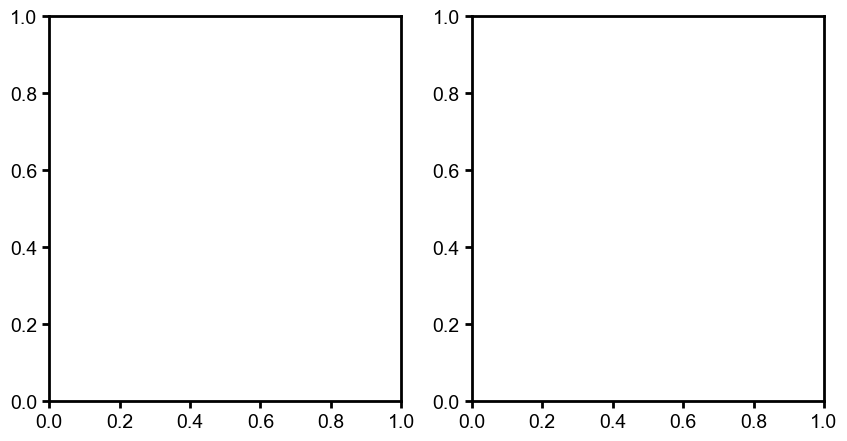

In [6]:
# load the data
patch_size = 80

pcnn_path = data_path + '/pcnn'
gaussian_path = data_path + '/gaussian'

# determine num replicates by number of files in directory
num_replicates = len([f for f in os.listdir(pcnn_path) if 'single_lens_pcnn' in f])

# load the data
single_lens_pcnn_data = []
double_lens_pcnn_data = []
many_lens_pcnn_data = []

single_lens_gaussian_data = []
double_lens_gaussian_data = []
many_lens_gaussian_data = []

for i in range(num_replicates):
    single_lens_pcnn_data.append(np.load(os.path.join(pcnn_path, f'single_lens_pcnn_patch_{patch_size}_{i}.npy')))
    double_lens_pcnn_data.append(np.load(os.path.join(pcnn_path, f'double_lens_pcnn_patch_{patch_size}_{i}.npy')))
    many_lens_pcnn_data.append(np.load(os.path.join(pcnn_path, f'many_lens_pcnn_patch_{patch_size}_{i}.npy')))

    single_lens_gaussian_data.append(np.load(os.path.join(gaussian_path, f'single_lens_gaussian_patch_{patch_size}_{i}.npy')))
    double_lens_gaussian_data.append(np.load(os.path.join(gaussian_path, f'double_lens_gaussian_patch_{patch_size}_{i}.npy')))
    many_lens_gaussian_data.append(np.load(os.path.join(gaussian_path, f'many_lens_gaussian_patch_{patch_size}_{i}.npy')))


# plot it 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.array(single_lens_pcnn_data), label='Single lens')
ax[0].plot(np.array(double_lens_pcnn_data), label='Double lens')
ax[0].plot(np.array(many_lens_pcnn_data), label='Many lens')
ax[0].legend()

ax[1].plot(np.array(single_lens_gaussian_data), label='Single lens')
ax[1].plot(np.array(double_lens_gaussian_data), label='Double lens')
ax[1].plot(np.array(many_lens_gaussian_data), label='Many lens')
ax[1].legend()
